# Continuity WIP

## Prepare data

/Users/gareth/dev/benchmark-urbanism/cityseer-api/__pypackages__/3.9/lib/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
INFO:cityseer.tools.mock:UTM conversion info: UTM zone number: 35, UTM zone letter: T
INFO:cityseer.tools.graphs:Converting networkX graph from WGS to UTM.
INFO:cityseer.tools.graphs:Processing node x, y coordinates.
100%|██████████| 39959/39959 [00:02<00:00, 18004.37it/s]
INFO:cityseer.tools.graphs:UTM conversion info: UTM zone number: 35, UTM zone letter: T
INFO:cityseer.tools.graphs:Processing edge geom coordinates, if present.
100%|██████████| 45231/45231 [00:00<00:00, 811479.58it/s]


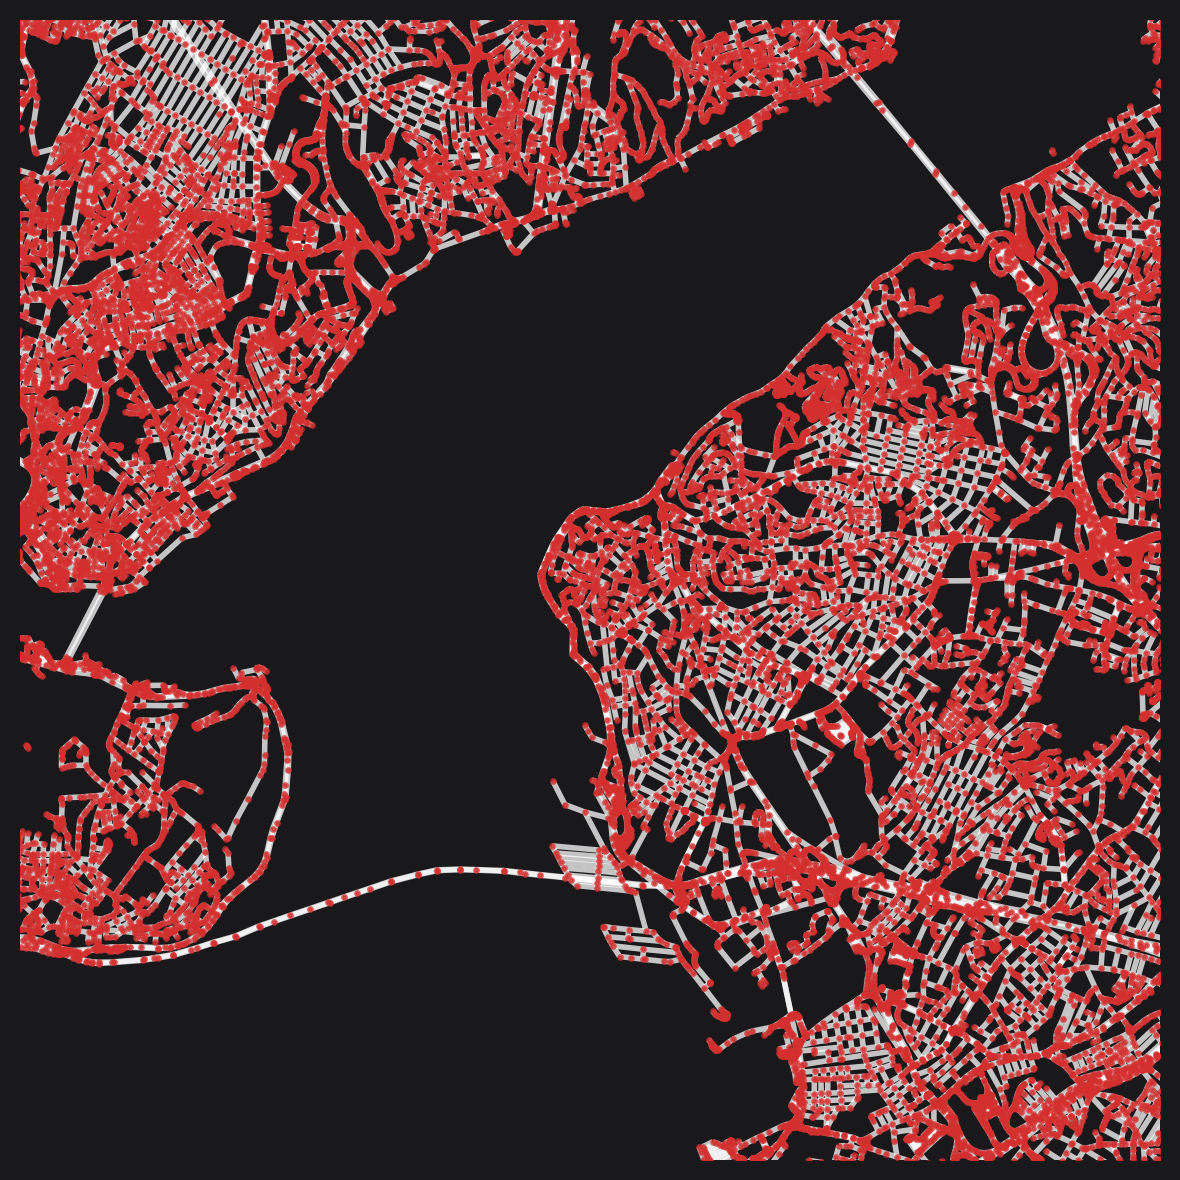

In [1]:
from shapely import geometry
import utm

from cityseer.tools import graphs, plot, mock

# Download data within a buffer around London Soho:
# lng, lat = -0.13039709427587876, 51.516434828344366  # london
# lng, lat = 18.425702641104582, -33.9204746754594  # cape town
lng, lat = 29.01011384485918, 41.021325648742206  # istanbul
buffer = 5000
query = """
[out:json][timeout:25];
(
    way["highway"]
    ["area"!="yes"]
    ["highway"!~"footway|pedestrian|steps|bus_guideway|escape|raceway|proposed|planned|abandoned|platform|construction"]
    (poly:"{geom_osm}");
);
out body;
>;
out qt;
"""
G_utm = mock.make_buffered_osm_graph(lng, lat, buffer, with_data=True, custom_request=query)

# select extents for plotting
easting, northing = utm.from_latlon(lat, lng)[:2]
buff = geometry.Point(easting, northing).buffer(buffer * 0.7)
min_x, min_y, max_x, max_y = buff.bounds


# reusable plot function
def simple_plot(_G, plot_geoms=True):
    # plot using the selected extents
    plot.plot_nx(
        _G,
        labels=False,
        plot_geoms=plot_geoms,
        node_size=2,
        edge_width=2,
        x_lim=(min_x, max_x),
        y_lim=(min_y, max_y),
        figsize=(6, 6),
        dpi=200,
    )


# plot of raw data from OSM
simple_plot(G_utm, plot_geoms=False)

## Clean graph

# Cleaning

For this form of analysis, only basic cleaning is recommended:
- not consolidating nodes because this risks accidentally dropping highway / ref / name attributes
- not like closeness or betweenness methods, where topological distortions are arguably a bigger issue

INFO:cityseer.tools.graphs:Generating simple (straight) edge geometries.
100%|██████████| 45231/45231 [00:00<00:00, 77489.40it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 39959/39959 [00:08<00:00, 4771.70it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 11896/11896 [00:00<00:00, 274434.25it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 11736/11736 [00:00<00:00, 169936.62it/s]


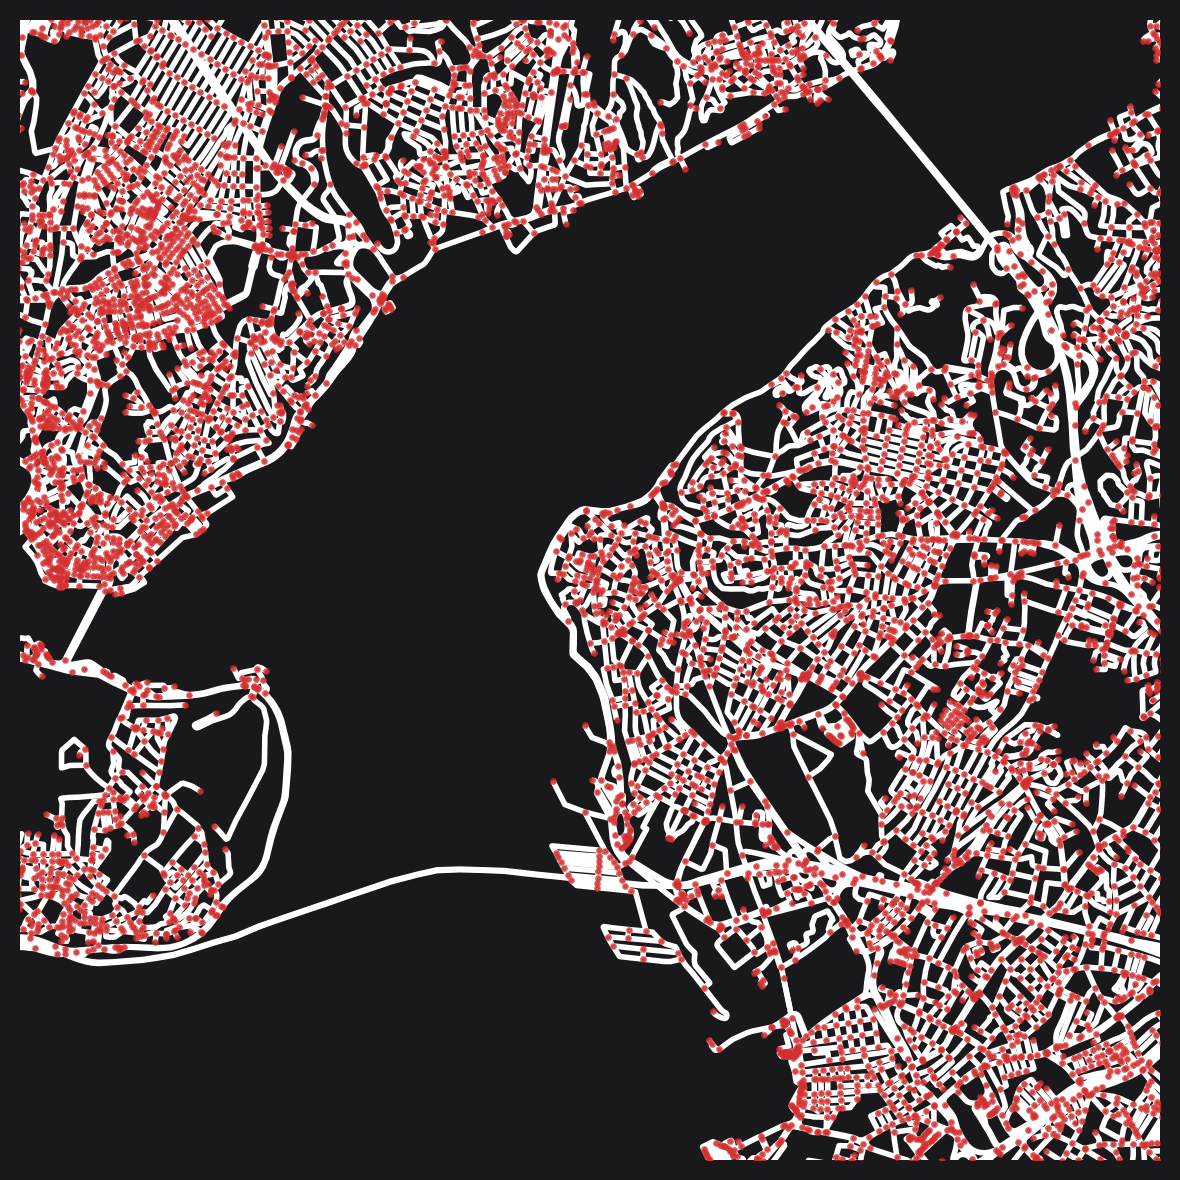

In [2]:
G = graphs.nx_simple_geoms(G_utm)
G = graphs.nx_remove_filler_nodes(G)
G = graphs.nx_remove_dangling_nodes(G, despine=20, remove_disconnected=True)
G = graphs.nx_remove_filler_nodes(G)
simple_plot(G)

## create method

In [3]:
import networkx as nx
from tqdm import tqdm
from cityseer.tools.graphs import NodeKey, EdgeData


def route_continuity(nx_multigraph: nx.MultiGraph, method: str):
    """ """

    def _clean_vals(vals: list[str]) -> set[str]:
        clean_vals: list[str] = []
        for val in vals:
            # highways category has residential, service, etc.
            if val not in [None, "residential", "service", "footway"]:
                clean_vals.append(val)
        return set(clean_vals)

    def _intersect_vals(vals_a: list[str], vals_b: list[str]) -> bool:
        clean_vals_a = _clean_vals(vals_a)
        clean_vals_b = _clean_vals(vals_b)
        itx = clean_vals_a.intersection(clean_vals_b)
        return len(itx) > 0

    def _recurse_edges(
        _nx_multigraph: nx.MultiGraph,
        _target_key: str,
        _target_vals: list[str],
        _a_nd_key: NodeKey,
        _b_nd_key: NodeKey,
        _edge_idx: int,
        agg_edge_lengths: list[float],
        visited_edges: list[str] = [],
    ):
        edge_nodes = tuple(sorted([str(_a_nd_key), str(_b_nd_key)]))
        edge_key = f"{edge_nodes[0]}_{edge_nodes[1]}_{_edge_idx}"
        if edge_key in visited_edges:
            return
        else:
            visited_edges.append(edge_key)
        nested_edge_data: EdgeData = _nx_multigraph[_a_nd_key][_b_nd_key][_edge_idx]
        if _target_key not in nested_edge_data:
            return
        nested_target_vals: list[str] = nested_edge_data[_target_key]
        if not _intersect_vals(_target_vals, nested_target_vals):
            return
        agg_edge_lengths.append(nested_edge_data["geom"].length)
        # find all neighbouring edge pairs
        a_nb_pairs: list[tuple[NodeKey, NodeKey]] = [
            (_a_nd_key, ann) for ann in nx.neighbors(_nx_multigraph, _a_nd_key) if ann != _b_nd_key  # type: ignore
        ]
        b_nb_pairs: list[tuple[NodeKey, NodeKey]] = [
            (_b_nd_key, bnn) for bnn in nx.neighbors(_nx_multigraph, _b_nd_key) if bnn != _a_nd_key  # type: ignore
        ]
        for nested_a_nd_key, nested_b_nd_key in a_nb_pairs + b_nb_pairs:
            nested_edge_idx: int
            for nested_edge_idx in _nx_multigraph[nested_a_nd_key][nested_b_nd_key].keys():
                _recurse_edges(
                    _nx_multigraph,
                    _target_key,
                    _target_vals,
                    nested_a_nd_key,
                    nested_b_nd_key,
                    nested_edge_idx,
                    agg_edge_lengths,
                    visited_edges,
                )

    if method in ["names", "refs", "highways"]:
        target_key: str = method
    else:
        raise ValueError(f"Method of {method} is not recognised.")
    # iter edges
    for a_nd_key, b_nd_key, edge_idx, edge_data in tqdm(nx_multigraph.edges(keys=True, data=True)):  # type: ignore
        if target_key not in edge_data:
            nx_multigraph[a_nd_key][b_nd_key][edge_idx][f"{target_key}_agg"] = None
        target_vals = edge_data[target_key]
        agg_edge_lengths: list[float] = []
        visited_edges: list[str] = []
        _recurse_edges(
            nx_multigraph, target_key, target_vals, a_nd_key, b_nd_key, edge_idx, agg_edge_lengths, visited_edges
        )
        # length sum
        agg_len = sum(agg_edge_lengths)
        if f"{target_key}_agg" in nx_multigraph[a_nd_key][b_nd_key][edge_idx]:
            current_agg_len = nx_multigraph[a_nd_key][b_nd_key][edge_idx][f"{target_key}_agg_length"]
            if agg_len > current_agg_len:
                nx_multigraph[a_nd_key][b_nd_key][edge_idx][f"{target_key}_agg_length"] = agg_len
        else:
            nx_multigraph[a_nd_key][b_nd_key][edge_idx][f"{target_key}_agg_length"] = agg_len
        # counts
        agg_count = len(agg_edge_lengths)
        if f"{target_key}_agg_count" in nx_multigraph[a_nd_key][b_nd_key][edge_idx]:
            current_agg_count = nx_multigraph[a_nd_key][b_nd_key][edge_idx][f"{target_key}_agg_count"]
            if agg_count > current_agg_count:
                nx_multigraph[a_nd_key][b_nd_key][edge_idx][f"{target_key}_agg_count"] = agg_count
        else:
            nx_multigraph[a_nd_key][b_nd_key][edge_idx][f"{target_key}_agg_count"] = agg_count

## run

1 - Street Names
2 - Refs - e.g. highway numbers
3 - OSM Highway classifications

In [4]:
G_agg = G.copy()
route_continuity(G_agg, method="names")
route_continuity(G_agg, method="refs")
route_continuity(G_agg, method="highways")

100%|██████████| 16905/16905 [00:53<00:00, 314.35it/s] 


## plot method

In [5]:
from cityseer.tools import plot
import numpy as np
import numpy.typing as npt
import networkx as nx
import matplotlib.pyplot as plt


def plot_aggs(edge_metrics_key: str):
    _fig, ax = plt.subplots(1, 1, dpi=200, figsize=(10, 10))
    # extract data for shaping
    edge_vals: list[str] = []
    edge_geoms: list[geometry.LineString] = []
    for _, _, edge_data in G_agg.edges(data=True):
        edge_vals.append(edge_data[edge_metrics_key])
        edge_geoms.append(edge_data["geom"])
    edge_vals_arr: npt.NDArray[np.float_] = np.array(edge_vals)
    edge_vals_arr = np.clip(edge_vals_arr, np.percentile(edge_vals_arr, 1), np.percentile(edge_vals_arr, 99))
    # plot using geoms
    for edge_val, edge_geom in zip(edge_vals, edge_geoms):
        xs = [c[0] for c in edge_geom.coords]
        ys = [c[1] for c in edge_geom.coords]
        # normalise val
        norm_val = (edge_val - edge_vals_arr.min()) / (edge_vals_arr.max() - edge_vals_arr.min())
        val_shape = norm_val * 0.95 + 0.05
        ax.plot(xs, ys, linewidth=val_shape, color="#ef1a33")
    ax.axis("off")
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)

# Plot street name continuity

A - by count
B - by length

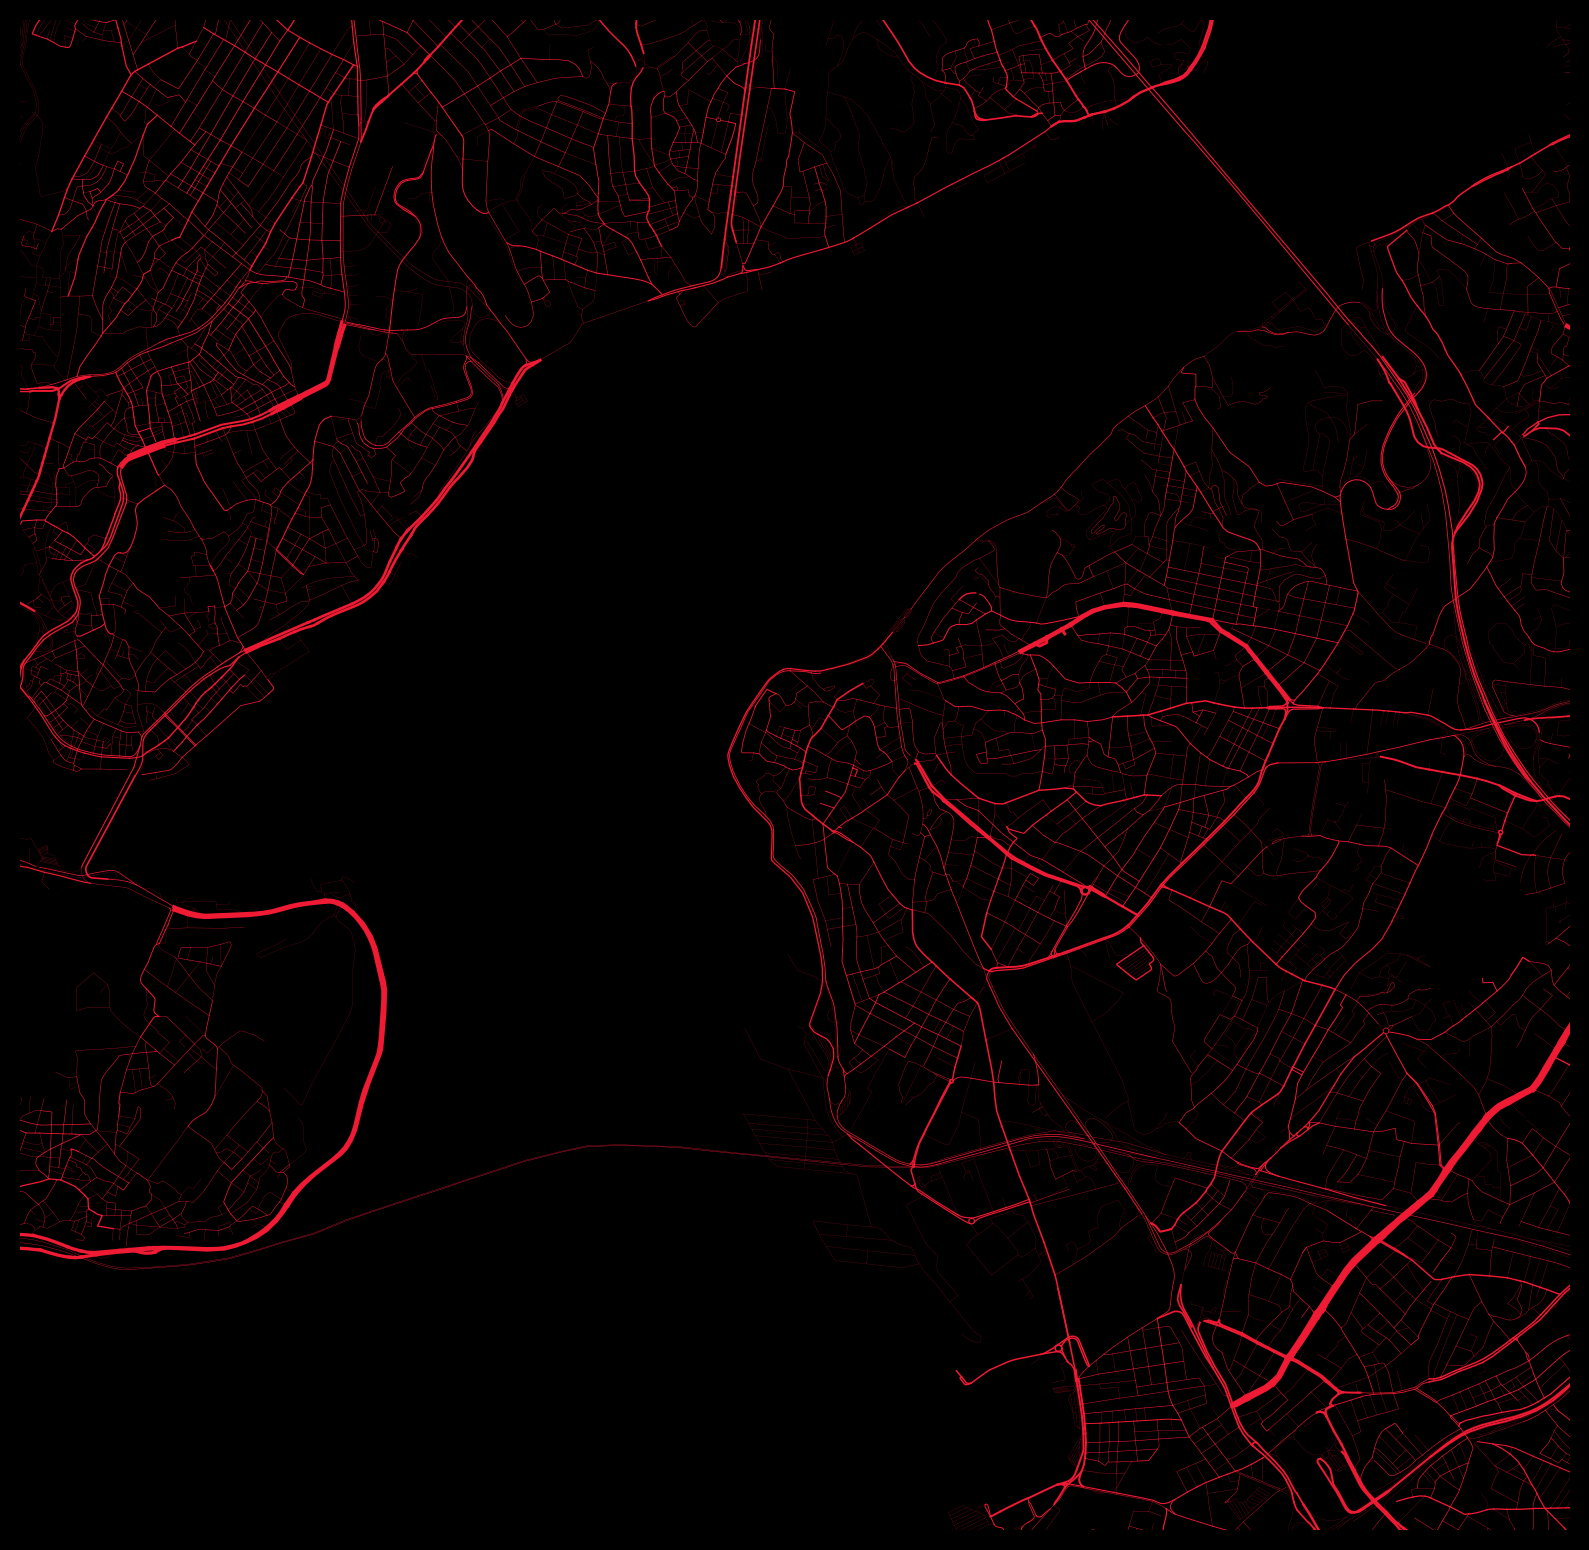

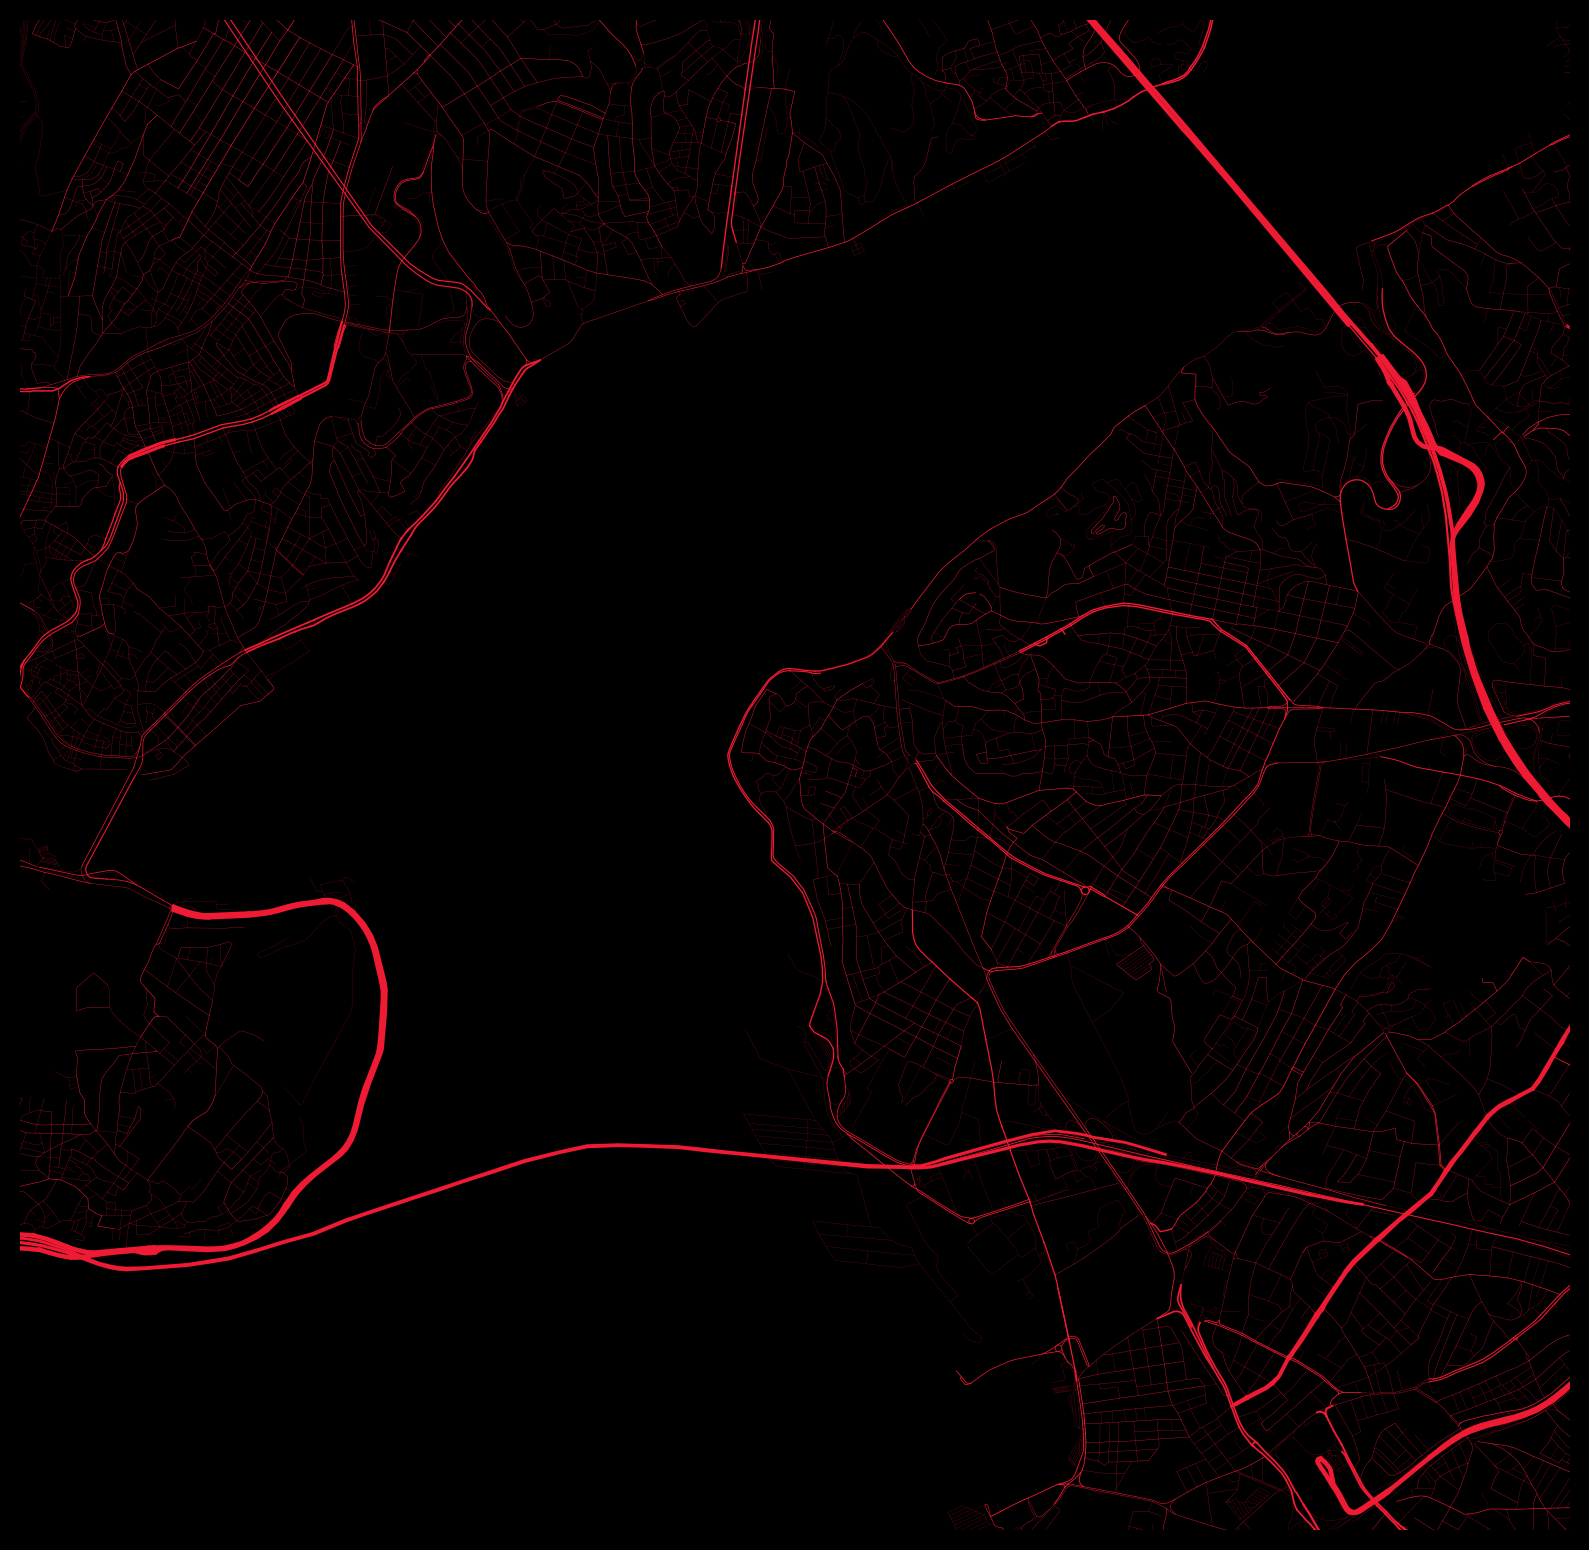

In [6]:
plot_aggs("names_agg_count")
plot_aggs("names_agg_length")

# Plot street ref continuity

A - by count
B - by length

In [7]:
plot_aggs("refs_agg_count")
plot_aggs("refs_agg_length")

/var/folders/bs/sq3p18cs4dn1ws4kpmfyk_3c0000gn/T/ipykernel_91684/3290691159.py:23: RuntimeWarning: invalid value encountered in double_scalars
  norm_val = (edge_val - edge_vals_arr.min()) / (edge_vals_arr.max() - edge_vals_arr.min())
/var/folders/bs/sq3p18cs4dn1ws4kpmfyk_3c0000gn/T/ipykernel_91684/3290691159.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  norm_val = (edge_val - edge_vals_arr.min()) / (edge_vals_arr.max() - edge_vals_arr.min())


OverflowError: Exceeded cell block limit in Agg, however for the following reasons:

- path.should_simplify is False

we can not automatically split up this path to draw.

Please manually simplify your path.

<Figure size 2000x2000 with 1 Axes>

OverflowError: Exceeded cell block limit in Agg, however for the following reasons:

- path.should_simplify is False

we can not automatically split up this path to draw.

Please manually simplify your path.

<Figure size 2000x2000 with 1 Axes>

# Plot street highway continuity

A - by count
B - by length

In [ ]:
plot_aggs("highways_agg_count")
plot_aggs("highways_agg_length")